# Mapping in Python

> **Co-author**
- [Kim Ruhl *University of Wisconsin*](http://kimjruhl.com)


**Prerequisites**

- [matplotlib Introduction](../pandas/matplotlib.ipynb)  
- [Visualization Rules](visualization_rules.ipynb)  


**Outcomes**

- Use geopandas to create maps  

## Outline

- [Mapping in Python](#Mapping-in-Python)  
  - [Mapping in Python](#Mapping-in-Python)  
  - [Case Study: Voting in Wisconsin](#Case-Study:-Voting-in-Wisconsin)  

In [1]:
# Uncomment following line to install on colab
#! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

ModuleNotFoundError: No module named 'qeds'

## Mapping in Python

In this lecture, we will use a new package, `geopandas`, to create maps.

Maps are really quite complicated… We are trying to project a spherical surface onto a flat figure, which is an
inherently complicated endeavor.

Luckily, `geopandas` will do most of the heavy lifting for us.

Let’s start with a DataFrame that has the latitude and longitude coordinates of various South American cities.

Our goal is to turn them into something we can plot – in this case, a `GeoDataFrame`.

In [3]:
df = pd.DataFrame({
    'City': ['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas'],
    'Country': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela'],
    'Latitude': [-34.58, -15.78, -33.45, 4.60, 10.48],
    'Longitude': [-58.66, -47.91, -70.66, -74.08, -66.86]
})

In order to map the cities, we need tuples of coordinates.

We generate them by zipping the latitude and longitude together to store them in a new column named `Coordinates`.

In [4]:
df["Coordinates"] = list(zip(df.Longitude, df.Latitude))
df.head()

,City,Country,Latitude,Longitude,Coordinates
0,Buenos Aires,Argentina,-34.58,-58.66,"(-58.66, -34.58)"
1,Brasilia,Brazil,-15.78,-47.91,"(-47.91, -15.78)"
2,Santiago,Chile,-33.45,-70.66,"(-70.66, -33.45)"
3,Bogota,Colombia,4.60,-74.08,"(-74.08, 4.6)"
4,Caracas,Venezuela,10.48,-66.86,"(-66.86, 10.48)"


Our next step is to turn the tuple into a `Shapely` `Point` object.

We will do this by applying Shapely’s `Point` method to the `Coordinates` column.

In [5]:
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,City,Country,Latitude,Longitude,Coordinates
0,Buenos Aires,Argentina,-34.58,-58.66,POINT (-58.66 -34.58)
1,Brasilia,Brazil,-15.78,-47.91,POINT (-47.91 -15.78)
2,Santiago,Chile,-33.45,-70.66,POINT (-70.66 -33.45)
3,Bogota,Colombia,4.60,-74.08,POINT (-74.08 4.6)
4,Caracas,Venezuela,10.48,-66.86,POINT (-66.86 10.48)


Finally, we will convert our DataFrame into a GeoDataFrame by calling the
geopandas.DataFrame method.

Conveniently, a GeoDataFrame is a data structure with the convenience of a
normal DataFrame but also an understanding of how to plot maps.

In the code below, we must specify the column that contains the geometry data.

See this excerpt from the docs

> The most important property of a GeoDataFrame is that it always has one GeoSeries column that
holds a special status. This GeoSeries is referred to as the GeoDataFrame’s “geometry”. When a
spatial method is applied to a GeoDataFrame (or a spatial attribute like area is called), this
commands will always act on the “geometry” column.

In [6]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,City,Country,Latitude,Longitude,Coordinates
0,Buenos Aires,Argentina,-34.58,-58.66,POINT (-58.66000 -34.58000)
1,Brasilia,Brazil,-15.78,-47.91,POINT (-47.91000 -15.78000)
2,Santiago,Chile,-33.45,-70.66,POINT (-70.66000 -33.45000)
3,Bogota,Colombia,4.60,-74.08,POINT (-74.08000 4.60000)
4,Caracas,Venezuela,10.48,-66.86,POINT (-66.86000 10.48000)


In [7]:
# Doesn't look different than a vanilla DataFrame...let's make sure we have what we want
print('gdf is of type:', type(gdf))

# And how can we tell which column is the geometry column?
print('\nThe geometry column is:', gdf.geometry.name)

gdf is of type: <class 'geopandas.geodataframe.GeoDataFrame'>

The geometry column is: Coordinates


### Plotting a Map

Great, now we have our points in the GeoDataFrame.

Let’s plot the locations on a map.

This will require 3 steps

1. Get the map  
1. Plot the map  
1. Plot the points (our cities) on the map  

#### 1. Get the map

An organization called [Natural Earth](https://www.naturalearthdata.com/) compiled the map data
that we use here.

The file provides the outlines of countries, over which we’ll plot the city locations
from our GeoDataFrame.

Luckily, `geopandas` already comes bundled with this data, so we don’t
have to hunt it down!

In [8]:
# Grab low resolution world file
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


`world` is a GeoDataFrame with the following columns:

- `pop_est`: Contains a population estimate for the country  
- `continent`: The country’s continent  
- `name`: The country’s name  
- `iso_a3`: The country’s 3 letter abbreviation (we made this the index)  
- `gdp_md_est`: An estimate of country’s GDP  
- `geometry`: A `POLYGON` for each country (we will learn more about these soon)  

In [9]:
world.geometry.name

'geometry'

Notice that the geometry for this GeoDataFrame is stored in the `geometry` column.

**A quick note about polygons**

Instead of points (as our cities are), the geometry objects are now polygons.

A polygon is what you already likely think it is – a collection of ordered points
connected by straight lines.

The smaller the distance between the points, the more readily the polygon can approximate
non-linear shapes.

Let’s see an example of a polygon.

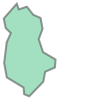

In [10]:
world.loc["ALB", 'geometry']

Notice that it displayed the country of Albania.

In [11]:
# Returns two arrays that hold the x and y coordinates of the points that define the polygon's exterior.
x, y = world.loc["ALB", "geometry"].exterior.coords.xy

# How many points?
print('Points in the exterior of Albania:', len(x))

Points in the exterior of Albania: 24


Let’s see another

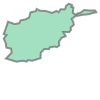

In [12]:
world.loc["AFG", "geometry"]

In [13]:
# Returns two arrays that hold the x and y coordinates of the points that define the polygon's exterior.
x, y = world.loc["AFG", 'geometry'].exterior.coords.xy

# How many points?
print('Points in the exterior of Afghanistan:', len(x))

Points in the exterior of Afghanistan: 69


Notice that we’ve now displayed Afghanistan.

This is a more complex shape than Albania and thus required more points.

#### 2. Plotting the map

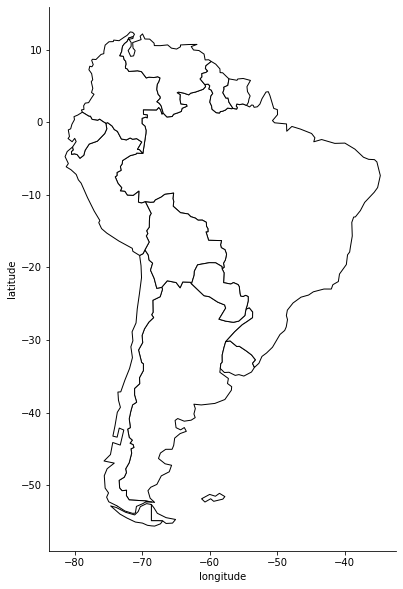

In [14]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("continent == 'South America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

Creating this map may have been easier than you expected!

In reality, a lot of heavy lifting is going on behind the scenes.

Entire university classes (and even majors!) focus on the theory and thought
that goes into creating maps, but, for now, we are happy to rely on the work done by the
experts behind `geopandas` and its related libraries.

#### 3. Plot the cities

In the code below, we run the same commands as before to plot the South American countries, but
, now, we also plot the data in `gdf`, which contains the location of South American cities.

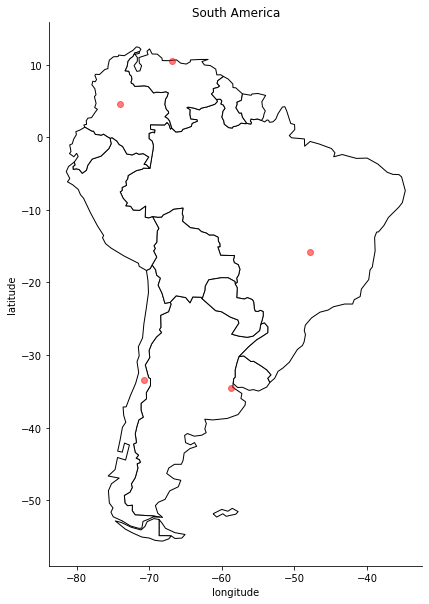

In [15]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("continent == 'South America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('South America')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

**Adding labels to points**.

Finally, we might want to consider annotating the cities so we know which cities are which.

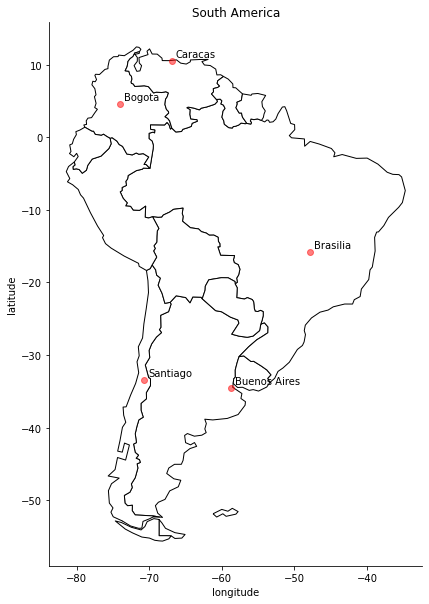

In [16]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well, South America.
world.query("continent == 'South America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame. I want the
# cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('South America')

# Kill the spines...
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

# ...or get rid of all the axis. Is it important to know the lat and long?
# plt.axis('off')


# Label the cities
for x, y, label in zip(gdf['Coordinates'].x, gdf['Coordinates'].y, gdf['City']):
    gax.annotate(label, xy=(x,y), xytext=(4,4), textcoords='offset points')

plt.show()

## Case Study: Voting in Wisconsin

In the example that follows, we will demonstrate how each county in Wisconsin voted during the 2016
Presidential Election.

Along the way, we will learn a couple of valuable lessons:

1. Where to find shape files for US states and counties  
1. How to match census style data to shape files  

### Find and Plot State Border

Our first step will be to find the border for the state of interest. This can be found on the [US
Census’s website here](https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html).

You can download the `cb_2016_us_state_5m.zip` by hand, or simply allow `geopandas` to extract
the relevant information from the zip file online.

In [17]:
state_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_5m.zip")
state_df.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,01,01779775,0400000US01,01,AL,Alabama,00,131173688951,4593686489,"MULTIPOLYGON (((-88.04374 30.51742, -88.03661 ..."
1,02,01785533,0400000US02,02,AK,Alaska,00,1477946266785,245390495931,"MULTIPOLYGON (((-133.65582 55.62562, -133.6249..."
2,04,01779777,0400000US04,04,AZ,Arizona,00,294198560125,1027346486,"POLYGON ((-114.79968 32.59362, -114.80939 32.6..."
3,08,01779779,0400000US08,08,CO,Colorado,00,268429343790,1175112870,"POLYGON ((-109.06025 38.59933, -109.05954 38.7..."
4,09,01779780,0400000US09,09,CT,Connecticut,00,12542638347,1815476291,"POLYGON ((-73.72777 41.10070, -73.69595 41.115..."


In [18]:
print(state_df.columns)

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')


We have various columns, but, most importantly, we can find the right geometry by filtering by name.

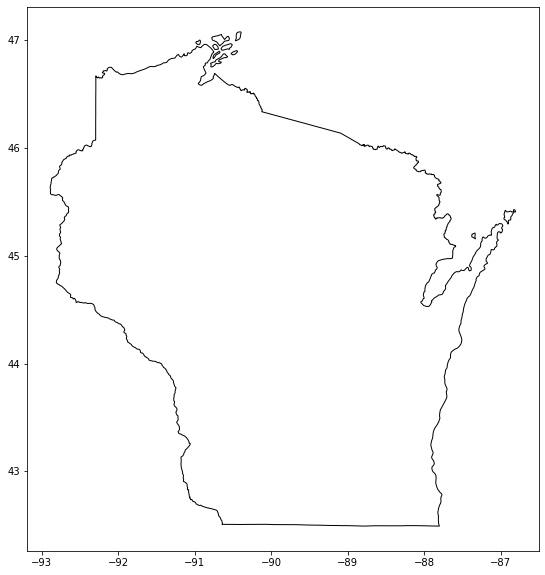

In [19]:
fig, gax = plt.subplots(figsize=(10, 10))
state_df.query("NAME == 'Wisconsin'").plot(ax=gax, edgecolor="black", color="white")
plt.show()

### Find and Plot County Borders

Next, we will add the county borders to our map.

The county shape files (for the entire US) can be found on the [Census
site](https://www.census.gov/geo/maps-data/data/cbf/cbf_counties.html).

Once again, we will use the 5m resolution.

In [20]:
county_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_5m.zip")
county_df.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,04,015,00025445,0500000US04015,04015,Mohave,06,34475567011,387344307,"POLYGON ((-114.75562 36.08717, -114.75364 36.0..."
1,12,035,00308547,0500000US12035,12035,Flagler,06,1257365642,221047161,"POLYGON ((-81.52366 29.62243, -81.32406 29.625..."
2,20,129,00485135,0500000US20129,20129,Morton,06,1889993251,507796,"POLYGON ((-102.04195 37.02474, -102.04195 37.0..."
3,28,093,00695770,0500000US28093,28093,Marshall,06,1828989833,9195190,"POLYGON ((-89.72432 34.99521, -89.64428 34.995..."
4,29,510,00767557,0500000US29510,29510,St. Louis,25,160458044,10670040,"POLYGON ((-90.31821 38.60002, -90.30183 38.655..."


In [21]:
print(county_df.columns)

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')


Wisconsin’s FIPS code is 55 so we will make sure that we only keep those counties.

In [22]:
county_df = county_df.query("STATEFP == '55'")

Now we can plot all counties in Wisconsin.

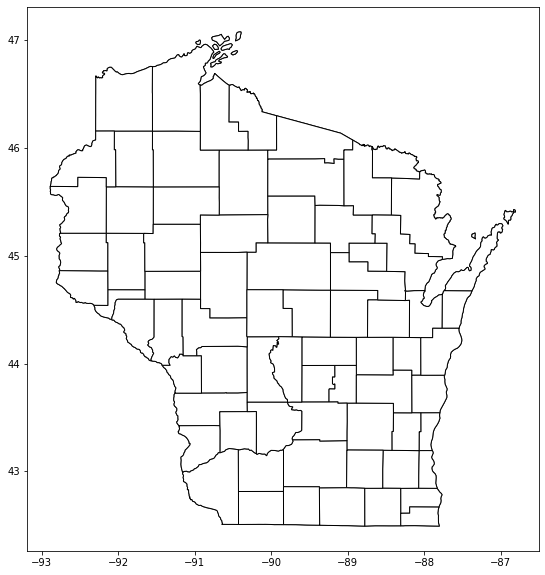

In [23]:
fig, gax = plt.subplots(figsize=(10, 10))

state_df.query("NAME == 'Wisconsin'").plot(ax=gax, edgecolor="black", color="white")
county_df.plot(ax=gax, edgecolor="black", color="white")

plt.show()

### Get Vote Data

The final step is to get the vote data, which can be found online on [this site](https://elections.wi.gov/elections-voting/results/2016/fall-general).

Our friend Kim says,

> Go ahead and open up the file. It’s a mess! I saved a cleaned up version of the file to
`results.csv` which we can use to save the hassle with cleaning the data. For fun, you should
load the raw data and try beating it into shape. That’s what you normally would have to do…
and it’s fun.


We’d like to add that such an exercise is also “good for you” (similar to how vegetables are good for you).

But, for the example in class, we’ll simply start with his cleaned data.

In [24]:
results = pd.read_csv("https://datascience.quantecon.org/assets/data/ruhl_cleaned_results.csv", thousands=",")
results.head()

HTTPError: HTTP Error 404: Not Found

Notice that this is NOT a GeoDataFrame; it has no geographical information.

But it does have the names of each county.

We will be able to use this to match to the counties from `county_df`.

First, we need to finish up the data cleaning.

In [25]:
results["county"] = results["county"].str.title()
results["county"] = results["county"].str.strip()
county_df["NAME"] = county_df["NAME"].str.title()
county_df["NAME"] = county_df["NAME"].str.strip()

NameError: name 'results' is not defined

Then, we can merge election results with the county data.

In [26]:
res_w_states = county_df.merge(results, left_on="NAME", right_on="county", how="inner")

NameError: name 'results' is not defined

Next, we’ll create a new variable called `trump_share`, which will denote the percentage of votes that
Donald Trump won during the election.

In [27]:
res_w_states["trump_share"] = res_w_states["trump"] / (res_w_states["total"])
res_w_states["rel_trump_share"] = res_w_states["trump"] / (res_w_states["trump"]+res_w_states["clinton"])
res_w_states.head()

NameError: name 'res_w_states' is not defined

Finally, we can create our map.

NameError: name 'res_w_states' is not defined

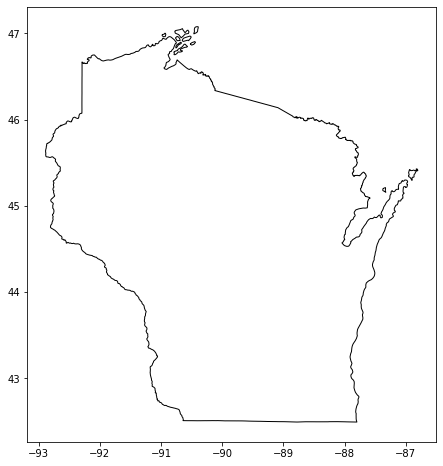

In [28]:
fig, gax = plt.subplots(figsize = (10,8))

# Plot the state
state_df[state_df['NAME'] == 'Wisconsin'].plot(ax = gax, edgecolor='black',color='white')

# Plot the counties and pass 'rel_trump_share' as the data to color
res_w_states.plot(
    ax=gax, edgecolor='black', column='rel_trump_share', legend=True, cmap='RdBu_r',
    vmin=0.2, vmax=0.8
)

# Add text to let people know what we are plotting
gax.annotate('Republican vote share',xy=(0.76, 0.06),  xycoords='figure fraction')

# I don't want the axis with long and lat
plt.axis('off')

plt.show()

What do you see from this map?

How many counties did Trump win? How many did Clinton win?

In [29]:
res_w_states.eval("trump > clinton").sum()

NameError: name 'res_w_states' is not defined

In [30]:
res_w_states.eval("clinton > trump").sum()

NameError: name 'res_w_states' is not defined

Who had more votes? Do you think a comparison in counties won or votes won is more reasonable? Why
do you think they diverge?

In [31]:
res_w_states["trump"].sum()

NameError: name 'res_w_states' is not defined

In [32]:
res_w_states["clinton"].sum()

NameError: name 'res_w_states' is not defined

What story could you tell about this divergence?

### Interactivity

Multiple Python libraries can help create interactive figures.

Here, we will see an example using bokeh.

In the another lecture, we will see an example with folium.

In [33]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.palettes import brewer
output_notebook()
import json
res_w_states["clinton_share"] = res_w_states["clinton"] / res_w_states["total"]
#Convert data to geojson for bokeh
wi_geojson=GeoJSONDataSource(geojson=res_w_states.to_json())

Loading BokehJS ...

NameError: name 'res_w_states' is not defined

In [34]:
color_mapper = LinearColorMapper(palette = brewer['RdBu'][10], low = 0, high = 1)
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')
hover = HoverTool(tooltips = [ ('County','@county'),('Portion Trump', '@trump_share'),
                               ('Portion Clinton','@clinton_share'),
                               ('Total','@total')])
p = figure(title="Wisconsin Voting in 2016 Presidential Election", tools=[hover])
p.patches("xs","ys",source=wi_geojson,
          fill_color = {'field' :'rel_trump_share', 'transform' : color_mapper})
p.add_layout(color_bar, 'below')
show(p)

NameError: name 'wi_geojson' is not defined